# LAB 5

This lab is about PARABOLIC problems, so we add the time evolution to our problem.

In [2]:
# Installation of firedrake
try:
  import firedrake
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  import firedrak

In [3]:
from firedrake import *
import matplotlib.pyplot as plt
import firedrake.pyplot as fdplt
from firedrake.output import VTKFile # For visulazation on Paraview
from time import perf_counter
import numpy as np

## EXERCISE 1:

On the unit square domain $\Omega = (0,1) \times (0,1)$ and time interval $I = (0, 1)$,
  we consider the initial and boundary value problem:
  $$
    \begin{cases}
      \dfrac{\partial u}{\partial t}- \Delta u = f  & \text{in } \Omega\times I, \\
      u = g                                         & \text{on } \partial\Omega\times I, \\
      {\left. u \right|}_{t=0} = u_0                & \text{on } \Omega, \\
    \end{cases}
$$ \\

(a)  Derive the weak formulation of problem (1). Then, write the semi-discrete formulation
obtained by discretizing the time derivative by the θ method.
where $$f = \left(\frac{\pi}{2} \cos(\pi t) + \pi^2 \sin(\pi t) \right) \sin(\pi x)  \sin(\pi y), \quad u_0=1, \quad g=1. $$ \\

(b) Derive the expression of f, g and u0 corresponding to the trigonometric solution given by: \\
$u(x, y, t) = 1 + \frac{1}{2}sin(πt)sin(πx)sin(πy)$ \\

\\

(c) Write a Firedrake solver and compute the FE approximation with:
• θ = 0 (explicit Euler method) and a number of mesh subdivisions n = 10. For the time step dt use values in {$10^{−1}, 10^{−2}, 10^{−4}$}.
• θ = 1 (implicit Euler method) and a number of mesh subdivisions n = 10. For the time step dt use values in {$10^{−1}, 10^{−2}, 10^{−4}$}. \\
What is the behavior of the solution for different values of dt? \\

\\

(d) Let $θ = \frac{1}{2}$ and $dt = 10^{−2}$. Compute the error of the numerical solution with respect to the exact solution in the $L^∞((0, 1), H^1(Ω))$ and $L^∞((0, 1), L^2(Ω))$ norms and fill the following table to assess the convergence rates in space: \\

Let $θ = \frac{1}{2}$ and $n = 10$. Compute the error of the numerical solution with respect to the exact solution in the $L^∞((0, 1), H^1(Ω))$ and $L^∞((0, 1), L^2(Ω))$ norms and fill the following table to assess the convergence rates in time: \\

\\

(e) Repeat the previous point using $θ =0$ and $θ = 1$. What is the behavior of the error and itsrate of convergence? \\

\\

(f) Using time.perf counter, compare the computational time for the solution in the cases of: \\
• reassembling the system at each time step and solving with standard parameters; \\
• assembling only at the start and computing the LU decomposition (see https://www.firedrakeproject.org/firedrake.html#firedrake.linear_solver.LinearSolver).\\

### a)  Derive the weak formulation of problem (1). Then, write the semi-discrete formulation obtained by discretizing the time derivative by the θ method.

Let: $u(x,t), v(x)$, then we can write the integral of our problem multiplied by $v(x)$ to get the weak formulation (same passages you can find in the elliptic theory): \\

\\

\begin{equation*}
\text{Find $u \in H^1_{g_D}(\Omega)$ , ∀$t<T$   s.t. } \int_\Omega \dfrac{\partial u}{\partial t} v \, \mathrm{d\Omega} + \int_\Omega \nabla u \cdot \nabla v \, \mathrm{d\Omega} = \int_\Omega f v \, \mathrm{d\Omega} \quad \forall v \in H^1_{0}(\Omega),
\end{equation*} \\

which can be rewritten as: \\

\begin{equation*}
\left( \dfrac{\partial u}{\partial t}, v\right)_{L^2(\Omega)} + a(u, v) = L(v).
\end{equation*} \\

\\

We first discretize in space, and then in time. \\

\\

**Semi-discretization in SPACE:** \\
The form used to write the Firedrake formulation is the semi-discrete in time weak form, to be described below.
The main point of the space discretization is that nodal values are allowed to vary in time, while the space dependence is given by the basis functions:
$$
u(\mathbf{x}, t) = \sum_{j=1}^{N_h} u_j(t) \, \phi_j(\mathbf{x}).
$$

We obtain the system of linear ODEs (procedure seen on theory of parabolic problems): \\

$$
M \dfrac{d \mathbf{u}}{dt} + A \mathbf{u} = \mathbf{f}.
$$ \\

\\

**TIME discretization (Θ-Method):** \\
We can write a semi-discrete formulation discretizing the time derivative as $\dfrac{d u}{d t} ≈ \frac{x_{k+1}-x_k}{Δt}$ with the θ-method: \\

$$
\dfrac{1}{\Delta t} M (\mathbf{u}^{k+1} - \mathbf{u}^k) + A [\theta \mathbf{u}^{k+1} + (1-\theta)\mathbf{u}^k] = \theta \mathbf{f}^{k+1} + (1-\theta)\mathbf{f}^k
$$ \\

or, rearranging: \\

$$
\left[\dfrac{1}{\Delta t} M + \theta A\right]\mathbf{u}^{k+1} = \left[\dfrac{1}{\Delta t} M - (1- \theta) A\right]\mathbf{u}^k + \theta \mathbf{f}^{k+1} + (1-\theta)\mathbf{f}^k.
$$ \\

where: \\

$$
m_{ij} = \int_\Omega \phi_i \phi_j \, \mathrm{d\Omega}, \quad
a_{ij} = \int_\Omega \nabla \phi_i \cdot \nabla \phi_j \, \mathrm{d\Omega}, \quad
f_{i} = \int_\Omega f v \, \mathrm{d\Omega}.
$$ \\

\\

**Semi-discrete in time weak form** \\
For the sake of implementation in Firedrake, we need the following formulation to build the needed forms: \\

$$
\underbrace{\left(\frac{u_{n+1}}{\Delta t},v \right)_\Omega
+\theta a(u_{n+1},v)}_{\tilde a(u_{n+1}, v)} =
\underbrace{\left(\frac{u_{n}}{\Delta t},v \right)_\Omega - (1-\theta) a(u_n,v) + \left(\theta f_{n+1} + (1-\theta) f_n,v\right)_\Omega}_{L(v)}
$$ \\

$$
⇒\tilde a(u_{n+1}, v)=L(v)
$$ \\

\\

In the code we will call $\tilde a$ simply $a$. The algebraic counterpart of $\tilde a(u, v)$  in the code is $A\mathbf{u}$, the one of $L$ is $\mathbf{b}$.

### (b) Derive the expression of $f$, $g$ and $u_0$ corresponding to the trigonometric solution given by: $u(x, y, t) = 1 + \frac{1}{2}sin(πt)sin(πx)sin(πy)$

Startinf from:
$$
u(x,y,t) = 1+\frac{1}{2}sin(πt)sin(πx)sin(πy) \\
$$
Then we can compute the derivatives:
$$
\frac{∂u}{∂t} = \frac{\pi}{2}cos({\pi t})sin(πx)sin(πy) \\
\frac{∂^2u}{∂x^2} = -\frac{\pi^2}{2}sin({\pi t})sin(πx)sin(πy) \\
\frac{∂^2u}{∂y^2} = -\frac{\pi^2}{2}sin({\pi t})sin(πx)sin(πy) \\
$$

Therefore the function $f$ is:
$$
f = \frac{∂u}{∂t} - Δu = \frac{\pi}{2}sin(πx)sin(πy)[cos({\pi t})+2πsin(πt)] \\
$$
With boundary conditions:
$$
u(0,y,t) = 1 \\
u(1,y,t) = 1 \\
$$

While $g$ is:
$$
g = u = 1+\frac{1}{2}sin(πt)sin(πx)sin(πy)
$$

### c) Write a Firedrake solver and compute the FE approximation with:
• θ = 0 (explicit Euler method) and a number of mesh subdivisions n = 10. For the time step dt use values in {$10^{−1}, 10^{−2}, 10^{−4}$}. \\
• θ = 1 (implicit Euler method) and a number of mesh subdivisions n = 10. For the time step dt use values in {$10^{−1}, 10^{−2}, 10^{−4}$}. \\
What is the behavior of the solution for different values of dt?

Let's first define the functions to solve our problem:

In [4]:
# Define the function to solve our problem:
def solver_hyperbolic(N,T,dt,theta, printings='no', plots='no'):
  '''
  Solve the hyperbolic equation with a NON optimized method with P1 elements
  INPUTS:
    N = Number of mesh subdivision
    T = Time domain
    dt = Time-step
    theta = Theta-paramiter for Theta-method
    printings = Select if you want to print the time steps
    plots = Select if you want to plot the result
  OUTPUTS:
    errL2 = Error in L2
    errH1 = Error in H1
    exact_time = time needed to solve the problem
  '''

  # Define the mesh
  mesh = UnitSquareMesh(N, N, diagonal='crossed')


  # Define the function space
  V = FunctionSpace(mesh, 'P', 1)
  x, y = SpatialCoordinate(mesh)


  # Define Boundary Conditions
  g = Constant(1.)
  bc = DirichletBC(V, g, 'on_boundary')


  # We need to make f an explicit function of t, since we need to vary t at
  # each step
  f_fun = lambda t: (pi/2*cos(pi*t) + pi**2*sin(pi*t)) * sin(pi*x) * sin(pi*y)


  # Variational formulation
  u = TrialFunction(V)
  v = TestFunction(V)


  # Firedrake wants the constant specified with the function 'Constant()'
  # otherwise he gives you error, so let's specify theta
  theta = Constant(theta)


  # Set initial quantities of time and solution
  t = 0 # Set initial time
  #
  u_ex = lambda t: 1 + 0.5 * sin(pi*t) * sin(pi*x) * sin(pi*y) # Exact solution
  #
  u_old = Function(V)
  u_old.assign(project(u_ex(t), V)) # We need to project because (same reason as lab 2&3)
  #
  errL2 = 0.
  errH1 = 0.
  #
  u_h = Function(V, name='Temperature') # We give a name to the solution
  u_h.assign(u_old)
  #
  start_time = perf_counter() # Compute the time needed to solve the problem


  # Iterative procedure to solve the problem:
  while t<T:

    # Update time
    t_old = t # Update previous t
    t += dt # Define the new t
    if printings=='yes':
      print('t = ', t)

    # Build the problem
    a = 1/dt * u * v * dx + theta * dot(grad(u), grad(v)) * dx
    L = ( 1/dt * u_old * v * dx - (1-theta) * (dot(grad(u_old), grad(v)) * dx)
          + theta * f_fun(t) * v * dx + (1-theta) * (f_fun(t_old) * v * dx) )
    solve(a==L, u_h, bcs=bc)
    u_old = u_h

    # Compute the error:
    # max over t is = ||u_h(t)-u_ex(t)||_H^1 <= C_1 delta t^p + C_2 h^r
    # If u_ex belongs to H^(r+1) and u_h belongs to P^r
    # P = {2 if zita = 0.5
    #     {1 all the other case
    errL2 = max(errL2, errornorm(u_ex(t), u_h, 'L2'))
    errH1 = max(errH1, errornorm(u_ex(t), u_h, 'H1'))

  exact_time = perf_counter() - start_time


  # Plot the solution (we plot it inside the function because with firedrake is
  # a mess to return the approximate solution and plot it
  if plots=='yes':
    print('----------------------------------------------------')
    print('Solution plot:')
    print('----------------------------------------------------')
    fig, ax = plt.subplots()
    q = fdplt.tripcolor(u_h, axes=ax)
    plt.colorbar(q)

  return errL2, errH1, exact_time

In [5]:
# Define the function to solve our problem:
def solver_hyperbolic_optimized(N,T,dt,theta, printings='no', plots='no'):
  '''
  Solve the hyperbolic equation with an optimized method and P1 element approx.
  INPUTS:
    N = Number of mesh subdivision
    T = Time domain
    dt = Time-step
    theta = Theta-paramiter for model used
    printings = Select if you want to print the time steps
    plots = Select if you want to plot the result
  OUTPUTS:
    errL2 = Error in L2
    errH1 = Error in H1
    exact_time = time needed to solve the problem
  '''

  # Define the mesh
  mesh = UnitSquareMesh(N, N, diagonal='crossed')

  # Define the function space
  V = FunctionSpace(mesh, 'P', 1)
  x, y = SpatialCoordinate(mesh)

  # Define Boundary Conditions
  g = Constant(1.)
  bc = DirichletBC(V, g, 'on_boundary')

  # We need to make f an explicit function of t, since we need to vary t at each
  # time step
  f_fun = lambda t: (pi/2*cos(pi*t) + pi**2*sin(pi*t)) * sin(pi*x) * sin(pi*y)

  # Exact solution
  u_ex = lambda t: 1 + 0.5 * sin(pi*t) * sin(pi*x) * sin(pi*y)

  # Set initial quantities of time and solution
  t = 0 # Set initial time
  u_old = Function(V)
  u_old.assign(project(u_ex(t), V)) # We need to project because...
  errL2 = 0.
  errH1 = 0.

  theta = Constant(theta) # Firedrake wants the constant specified with the function 'Constant()' otherwise he gives you error

  # Variational formulation
  u = TrialFunction(V)
  v = TestFunction(V)

  # For optimization we built our matrix in advance
  a = 1/dt * u * v * dx + theta * dot(grad(u), grad(v)) * dx # We place it here for optimization
  A = assemble(a, bcs=bc)

  # Set the solver
  solver = LinearSolver(A, solver_parameters={'ksp_type':'preonly',
                                              'pc_type':'lu'})

  # Problem definition
  u_h = Function(V, name='Temperature')
  u_h.assign(u_old)

  # Compute the time needed to solve the problem
  start_time = perf_counter()

  # Iterative procedure to solve the problem:
  while t<T:

    # Update time
    t_old = t # Update previous t
    t += dt # Define the new t
    if printings=='yes':
      print('t = ', t)

    # Build the problem
    L = ( 1/dt * u_old * v * dx - (1-theta) * (dot(grad(u_old), grad(v)) * dx)
          + theta * f_fun(t) * v * dx + (1-theta) * (f_fun(t_old) * v * dx) )
    b = assemble(L, bcs=bc)
    #solve(a==L, u_h, bcs=bc)
    solver.solve(u_h, b)
    u_old = u_h

    # Compute the error:
    # max over t is = ||u_h(t)-u_ex(t)||_H^1 <= C_1 delta t^p + C_2 h^r
    # If u_ex belongs to H^(r+1) and u_h belongs to P^r
    # P = {2 if zita = 0.5
    #     {1 all the other case
    errL2 = max(errL2, errornorm(u_ex(t), u_h, 'L2'))
    errH1 = max(errH1, errornorm(u_ex(t), u_h, 'H1'))

  exact_time = perf_counter() - start_time


  # Plot the solution (we plot it inside the function because with firedrake is a mess to return the approximate solution and plot it
  if plots=='yes':
    print('----------------------------------------------------')
    print('Solution plot:')
    print('----------------------------------------------------')
    fig, ax = plt.subplots()
    q = fdplt.tripcolor(u_h, axes=ax)
    plt.colorbar(q)

  return errL2, errH1, exact_time

#### Case 1 for:

*  $θ = 0$
*  $n = 10$
*  $dt$ in {$10^{−1}, 10^{−2}, 10^{−4}$}



tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any a

----------------------------------------------------
Solution plot:
----------------------------------------------------


(inf, inf, 264.38159705099997)

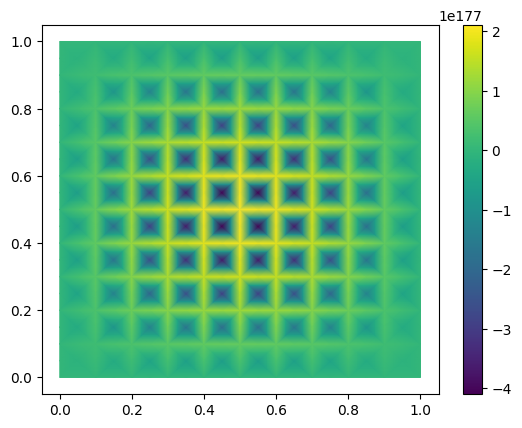

In [6]:
# Discretize the problem and set the timestep:
N = 10 # Discretization

T = 1. # Time domain

#dt = 0.1 # Time-step
dt = 0.01 # Time-step
#dt = 0.0001 # Time-step

theta = 0

# Solve:
solver_hyperbolic_optimized(N,T,dt,theta,plots='yes')


#### Case 2 for:

*  $θ = 1$
*  $n = 10$
*  $dt$ in {$10^{−1}, 10^{−2}, 10^{−4}$}



tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any a

----------------------------------------------------
Solution plot:
----------------------------------------------------


(0.007641155335578391, 0.09568152631269174, 23.594439216000183)

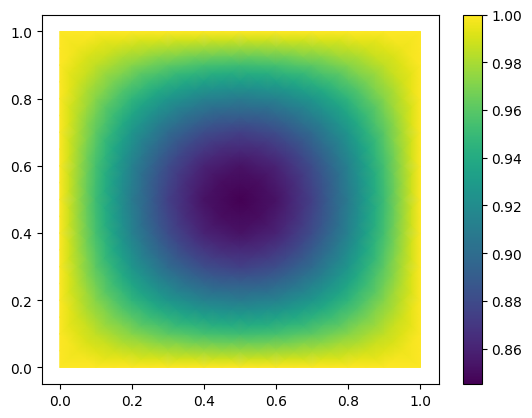

In [7]:
# Discretize the problem and set the timestep:
N = 10 # Discretization

T = 1. # Time domain

dt = 0.1 # Time-step
#dt = 0.01 # Time-step
#dt = 0.0001 # Time-step

theta = 1

# Solve:
solver_hyperbolic_optimized(N,T,dt,theta, plots='yes')

We see that the solution as $dt$ decreases takes more time to be obtained but is more accurate

In [8]:
# On colab, use this command to compress results for easier download
#!tar -czf results.zip results

### d) Let $θ = \frac{1}{2}$ and $dt = 10^{−2}$. Compute the error of the numerical solution with respect to the exact solution in the $L^∞((0, 1), H^1(Ω))$ and $L^∞((0, 1), L^2(Ω))$ norms and fill the following table to assess the convergence rates in space. Let $θ = \frac{1}{2}$ and $n = 10$. Compute the error of the numerical solution with respect to the exact solution in the $L^∞((0, 1), H^1(Ω))$ and $L^∞((0, 1), L^2(Ω))$ norms and fill the following table to assess the convergence rates in time


#### Case 1, for:

*  $θ = \frac{1}{2}$
*  $dt=10^{−2}$

In [9]:
# Discretize the problem and set the timestep:
N = np.array([5, 10, 20, 40]) # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = 0.01 # Time-step
#dt = 0.0001 # Time-step
theta = 0.5


for n in N:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(n,T,dt,theta)
  print('Error for n = ', n, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for n = ', n, 'in L^infty((0,T), H^1)  = ', errH1)
  print('------------------------------------------------------------')

Error for n =  5 in L^infty((0,T), L^2) =  0.007665290436971012
Error for n =  5 in L^infty((0,T), H^1)  =  0.18389032915784315
------------------------------------------------------------
Error for n =  10 in L^infty((0,T), L^2) =  0.0019114049319074774
Error for n =  10 in L^infty((0,T), H^1)  =  0.09195181045696728
------------------------------------------------------------
Error for n =  20 in L^infty((0,T), L^2) =  0.00047759800579389155
Error for n =  20 in L^infty((0,T), H^1)  =  0.04597694140821338
------------------------------------------------------------
Error for n =  40 in L^infty((0,T), L^2) =  0.00011948694237397746
Error for n =  40 in L^infty((0,T), H^1)  =  0.022988607497324415
------------------------------------------------------------


Here fro $θ=\frac{1}{2}$ we notice a good increasing of the convergence the more we reduce the size of the mesh.

#### Case 2, for:

*  $θ = \frac{1}{2}$
*  $n=10$

In [10]:
# Discretize the problem and set the timestep:
N = 10 # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = np.array([1., 0.5, 0.25, 0.125]) # Time-step
#dt = 0.0001 # Time-step
theta = 0.5

for ddt in dt:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(N,T,ddt,theta)
  print('Error for dt = ', ddt, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for dt = ', ddt, 'in L^infty((0,T), H^1)  = ', errH1)
  print('------------------------------------------------------------')

tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)


Error for dt =  1.0 in L^infty((0,T), L^2) =  3.5300597833067967e-09
Error for dt =  1.0 in L^infty((0,T), H^1)  =  1.6304345010254374e-07
------------------------------------------------------------
Error for dt =  0.5 in L^infty((0,T), L^2) =  0.01448828276421959
Error for dt =  0.5 in L^infty((0,T), H^1)  =  0.1003283650018877
------------------------------------------------------------


tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)


Error for dt =  0.25 in L^infty((0,T), L^2) =  0.003554938152124565
Error for dt =  0.25 in L^infty((0,T), H^1)  =  0.09195196466904136
------------------------------------------------------------


tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)
tsfc:WARNING Estimated quadrature degree 12 more than tenfold greater than any argument/coefficient degree (max 1)


Error for dt =  0.125 in L^infty((0,T), L^2) =  0.0019673599722923123
Error for dt =  0.125 in L^infty((0,T), H^1)  =  0.09195324756581613
------------------------------------------------------------


Here also for $θ=\frac{1}{2}$ we notice a very good convergence the more we increase the time discretization

### e) Repeat the previous point using $θ =0$ and $θ = 1$. What is the behavior of the error and its rate of convergence?

#### Case 1, for:

*  $θ = 0$
*  $dt=10^{−2}$

In [11]:
# Discretize the problem and set the timestep:
N = np.array([5, 10, 20, 40]) # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = 0.01 # Time-step
#dt = 0.0001 # Time-step
theta = 0.

for n in N:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(n,T,dt,theta)
  print('Error for n = ', n, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for n = ', n, 'in L^infty((0,T), H^1)  = ', errH1)
  print('------------------------------------------------------------')

Error for n =  5 in L^infty((0,T), L^2) =  2.561282951455081e+112
Error for n =  5 in L^infty((0,T), H^1)  =  1.0314622784781443e+114
------------------------------------------------------------
Error for n =  10 in L^infty((0,T), L^2) =  inf
Error for n =  10 in L^infty((0,T), H^1)  =  inf
------------------------------------------------------------
Error for n =  20 in L^infty((0,T), L^2) =  inf
Error for n =  20 in L^infty((0,T), H^1)  =  inf
------------------------------------------------------------
Error for n =  40 in L^infty((0,T), L^2) =  inf
Error for n =  40 in L^infty((0,T), H^1)  =  inf
------------------------------------------------------------


Here for $θ=0$ we notice a very bad convergence, instead taking too fine mesh the error goes to infinity

#### Case 2, for:

*  $θ = 0$
*  $n=10$

In [12]:
# Discretize the problem and set the timestep:
N = 10 # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = np.array([1., 0.5, 0.25, 0.125]) # Time-step
#dt = 0.0001 # Time-step
theta = 0.

for ddt in dt:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(N,T,ddt,theta)
  print('Error for dt = ', ddt, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for dt = ', ddt, 'in L^infty((0,T), H^1)  = ', errH1)
  print('------------------------------------------------------------')

Error for dt =  1.0 in L^infty((0,T), L^2) =  0.7853932976776155
Error for dt =  1.0 in L^infty((0,T), H^1)  =  3.5887760776747366
------------------------------------------------------------
Error for dt =  0.5 in L^infty((0,T), L^2) =  1.499791487138214
Error for dt =  0.5 in L^infty((0,T), H^1)  =  90.40104219127979
------------------------------------------------------------
Error for dt =  0.25 in L^infty((0,T), L^2) =  825222.4463648897
Error for dt =  0.25 in L^infty((0,T), H^1)  =  69084478.95222278
------------------------------------------------------------
Error for dt =  0.125 in L^infty((0,T), L^2) =  3.014538046863868e+16
Error for dt =  0.125 in L^infty((0,T), H^1)  =  2.523663265470801e+18
------------------------------------------------------------


Same as before, for $θ=0$ we get a horrible rate of convergence, the error increase the more you decrease the timestep.

#### Case 3, for:

*  $θ = 1$
*  $dt=10^{−2}$

In [13]:
# Discretize the problem and set the timestep:
N = np.array([5, 10, 20, 40]) # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = 0.01 # Time-step
#dt = 0.0001 # Time-step
theta = 1.

for n in N:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(n,T,dt,theta)
  print('Error for n = ', n, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for n = ', n, 'in L^infty((0,T), H^1)  = ', errH1)
  print('------------------------------------------------------------')

Error for n =  5 in L^infty((0,T), L^2) =  0.00818007561005608
Error for n =  5 in L^infty((0,T), H^1)  =  0.1839201990862751
------------------------------------------------------------
Error for n =  10 in L^infty((0,T), L^2) =  0.002463862151662701
Error for n =  10 in L^infty((0,T), H^1)  =  0.09199802721885379
------------------------------------------------------------
Error for n =  20 in L^infty((0,T), L^2) =  0.00105981775433642
Error for n =  20 in L^infty((0,T), H^1)  =  0.04606232997135732
------------------------------------------------------------
Error for n =  40 in L^infty((0,T), L^2) =  0.0007230302324286278
Error for n =  40 in L^infty((0,T), H^1)  =  0.02315541580987385
------------------------------------------------------------


For $θ=1$ instead we get good convergence rate

#### Case 4, for:

*  $θ = 1$
*  $n=10$

In [14]:
# Discretize the problem and set the timestep:
N = 10 # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = np.array([1., 0.5, 0.25, 0.125]) # Time-step
#dt = 0.0001 # Time-step
theta = 1.

for ddt in dt:
  errL2, errH1, exact_time = solver_hyperbolic_optimized(N,T,ddt,theta)
  print('Error for dt = ', ddt, 'in L^infty((0,T), L^2) = ', errL2)
  print('Error for dt = ', ddt, 'in L^infty((0,T), H^1)  = ', errH1)

Error for dt =  1.0 in L^infty((0,T), L^2) =  0.03762342787983325
Error for dt =  1.0 in L^infty((0,T), H^1)  =  0.17189874283788495
Error for dt =  0.5 in L^infty((0,T), L^2) =  0.024426719201487344
Error for dt =  0.5 in L^infty((0,T), H^1)  =  0.13888897937779215
Error for dt =  0.25 in L^infty((0,T), L^2) =  0.014951429464367401
Error for dt =  0.25 in L^infty((0,T), H^1)  =  0.11020794155882459
Error for dt =  0.125 in L^infty((0,T), L^2) =  0.009001042334194569
Error for dt =  0.125 in L^infty((0,T), H^1)  =  0.09756250831734037


For $θ=1$ we get good convergence rate

### f) Using time.perf counter, compare the computational time for the solution in the cases of:
• reassembling the system at each time step and solving with standard parameters; \\
• assembling only at the start and computing the LU decomposition (see https://www.firedrakeproject.org/firedrake.html#firedrake.linear_solver.LinearSolver)

In [15]:
# Discretize the problem and set the timestep:
N = 10 # Discretization
T = 1. # Time domain
#dt = 0.1 # Time-step
dt = 0.5 # Time-step
#dt = 0.0001 # Time-step
theta = 1.

errL2, errH1, exact_time_normal = solver_hyperbolic(N,T,dt,theta)
errL2, errH1, exact_time_opmz = solver_hyperbolic_optimized(N,T,dt,theta)

In [16]:
print('The time needed for the algorithm is: ', exact_time_normal)
print('------------------------------------------------------------------------------------')
print('The time needed for the optimized algorithm is: ',exact_time_opmz)

The time needed for the algorithm is:  3.2805287099999987
------------------------------------------------------------------------------------
The time needed for the optimized algorithm is:  0.0600755630000549


## EXERCISE 2:

Let again $Ω = (0, 2) × (0, 1)$ and consider the heat equation
$$
\frac{∂u}{∂t} − k∆u = 0 in Ω and t > 0
$$
where the temperature field is denoted by u and the thermal diffusivity by $k = 10^{−2}$. The initial distribution of temperature is uniform and equal to $u(·, t = 0) = 20$. The heat equation allows to determine the evolution in time of the temperature distribution u in Ω for t > 0. \\
The equation needs to be complemented with proper boundary conditions, which represent the interaction of the system with the surrounding environment for $t > 0$. Suppose that, for every
$t > 0$, the temperature is kept fixed at
$$
u = 40 on ΓD = {(x, y) ∈ ∂Ω | x = 0 and y ∈ (0, 1)}
$$ \\
while on the boundary
$$
ΓR = {(x, y) ∈ ∂Ω | x ∈ (0, 2) and y = 1}
$$
the material may exchange energy with the surrounding environment (owing to the difference of the temperature of the material with the temperature of the environment $u_{env} = 5$) according to
the linear Newton’s law of cooling
$$
−k∇u · ⃗n = α(u − uenv)
$$
where $α = 10^{−2}$. Finally, the remaining part of the boundary $∂Ω \ (ΓD ∪ ΓR)$ is adiabatic, i.e.
$$
−k∇u · ⃗n = 0.
$$ \\

(a) Write the complete differential problem given by equation (2) together with the initial condition and the boundary conditions (3), (4), and (5). Then, derive its weak formulation. \\

(b) Write a Firedrake solver for the problem using linear finite elements with $h = \frac{1}{10}$ and a time
discretization based on the implicit Euler scheme. \\

(c) Solve the problem until the final time $T_f = 200$ using time step $dt = 5$ and observe the time
evolution of the solution. \\

(d) (optional) Save the solution for visualization with Paraview (see https://www.firedrakeproject.
org/visualisation.html#creating-output-files).


### (a) Write the complete differential problem given by equation (2) together with the initial condition and the boundary conditions (3), (4), and (5). Then, derive its weak formulation.

#### The complete differential problem with boundary and initial conditions:

\\

$$
\begin{cases}
  \frac{\partial u}{\partial t} - k \Delta u = 0 \quad \text{in} \; \Omega \;\text{ and } \; t>0, \\
   u(t>0) = 40 \quad\text{ on }  
  \Gamma_D = \left\{(x,y)\in \partial\Omega \,|\, x = 0 \text{ and } y \in (0, 1) \right\}, \\
  -k\nabla u \cdot \vec{n} = α(u-u_{env}) \quad\text{ on }  
  \Gamma_R= \left\{(x,y) \in \partial\Omega \,|\, x \in (0, 2) \text{ and } y = 1\right\} \\
  -k\nabla u \cdot \vec{n} = 0 \quad\text{ on }  
  \partial \Omega \neq (\Gamma_{D} ∪ \Gamma_R) \\
\end{cases}
$$ \\



#### The weak formulation:

Recalling the weak formulation for the discrete formulation in time and space for the Θ-method: \\

\\

$$
\underbrace{\left(\frac{u_{n+1}}{\Delta t},v \right)_\Omega
+\theta a(u_{n+1},v)}_{\tilde a(u_{n+1}, v)} =
\underbrace{\left(\frac{u_{n}}{\Delta t},v \right)_\Omega - (1-\theta) a(u_n,v) + \left(\theta f_{n+1} + (1-\theta) f_n,v\right)_\Omega}_{L(v)}
$$ \\

Then for the IMPLICIT EULER (Θ=1) we get: \\

$$
\underbrace{\left(\frac{u_{n+1}}{\Delta t},v \right)_\Omega
+ a(u_{n+1},v)}_{\tilde a(u_{n+1}, v)} =
\underbrace{\left(\frac{u_{n}}{\Delta t},v \right)_\Omega + \left(f_{n+1} ,v\right)_\Omega}_{L(v)}
$$ \\



So applying it to the case of our complete problem: \\

$$
\underbrace{\left(\dfrac{u_{n+1}}{\Delta t},v \right)_\Omega
+ ka(u_{n+1},v) + (\alpha u, v)_{\Gamma_R}}_{\tilde a(u_{n+1},v)} = \underbrace{\left(\dfrac{u_{n}}{\Delta t},v \right)_\Omega
+ \left(f_{n+1} ,v\right)_\Omega + (\alpha u_\text{env}, v)_{\Gamma_R}}_{L(v)} \quad \forall n\in\{ 1, N_h\},
$$

### b) Write a Firedrake solver for the problem using linear finite elements with $h = \frac{1}{10}$ and a time discretization based on the implicit Euler scheme.

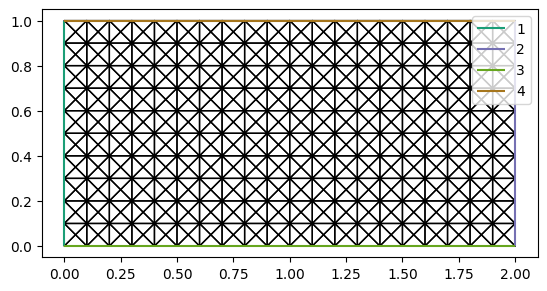

In [33]:
# Generate the mesh
lx, ly = 2., 1. # Dimension of the mesh on x and y
nx, ny = 20, 10 # Number of elements along x and y
mesh = RectangleMesh(nx, ny, lx, ly, diagonal='crossed')

# Plot the mesh
fig, ax = plt.subplots()
fdplt.triplot(mesh, axes=ax)
ax.legend()
ax.set_aspect('equal')

From the figure we can see that the Dirichlet boundary has label 1 and the Robin boundary has label 4. The others are Neumann (adiabatic) boundaries.

In [37]:
def solve_ex_2(T, dt, degree):
  # Definition of the finite dimentional space
  V = FunctionSpace(mesh, 'P', degree)


  # Set boundary conditions:
  bc = DirichletBC(V, Constant(40.0), 1) # 1 is the label associated to Diriclet


  # Define the space of the trial and test functions
  u = TrialFunction(V)
  v = TestFunction(V)


  # Set data:
  k = Constant(1.e-2)
  alpha = Constant(1.e-2)
  uEnv = Constant(5.0)


  # Implicit Euler formula: (theta=1)
  a = ( (u * v / dt) + (k * dot(grad(u), grad(v))) ) * dx + alpha * u * v * ds(4)
  #ds(4) because you see from the mesh plot thet Γ_R is the boundary named 4


  # Assemble the system to solve making the LU decomposition
  A = assemble(a, bcs=bc)
  solver = LinearSolver(A, solver_parameters={'ksp_type':'preonly', 'pc_type':'lu'})


  # Initialize the solution:
  u_h = Function(V, name='Temperature')


  # Set the initial condition:
  u_old = project(Constant(20), V) # Initial condition
  u_h.assign(u_old)


  # Solve the system for different time iterations:
  t = 0 # Initial time
  outfile = File('results/Heat-2.pvd') # Store the solution in a file to visualize them
  outfile.write(u_h, time=0)
  while t < T:
    t += dt # Increase time-step

    # Build L
    L = u_old * v / dt * dx + alpha * uEnv * v * ds(2)
    b = assemble(L, bcs=bc)

    # Solve for the i-th time-step
    solver.solve(u_h, b)
    u_old.assign(u_h)

    # export the solution at each time step
    outfile.write(u_h, time=t)


### c) Solve the problem until the final time $T_f = 200$ using time step $dt = 5$ and observe the time evolution of the solution.

In [35]:
# Set data:
T = 200.0
dt = 5.0
degree = 1

# Get the solution
solve_ex_2(T, dt, degree)

/usr/local/lib/python3.10/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


To visualize try to open the folder on paraview

### d) (optional) Save the solution for visualization with Paraview (see https://www.firedrakeproject.org/visualisation.html#creating-output-files)

In [32]:
# On colab, use this command to compress results for easier download
# If the above command produces a file that can't be opened (might happen on
# windows), use this and extract with 7zip:


# (uncomment if you want but it doesn't work well)
# !tar -czf results.7zip results

In [ ]:
# Alternative: mount google drive in colab and download from there
!tar -cvf results.tar results